# Dépendances et path

In [1]:
!pip install netCDF4
!pip install cftime
!pip install cartopy

In [2]:
import xarray as xr
import numpy as np
import os
import cftime
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import gc
from sklearn.decomposition import PCA
import pandas as pd
import scipy.stats as stats
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path='drive/MyDrive/projet/Data_precip_CESM2'

Le but ici est de regarder les résultats d'optimal fingerprint sur des données de précipitation

# Lecture des données

On regarde un fichier pour déterminer les variables du jeu de données:
on a un jeu qui ressemble au premier jeu traité à la première phase. Ici la variable précipitations qu'on va étudier est définie comme pr
on a 50 fichiers


In [ ]:
xarray=xr.open_dataset(path+'/'+os.listdir(path)[0])
xarray

on va prendre les données allant jusqu'à 2022

# Determiner beta

In [4]:
def reduce_granularity(ds, target_points):
    lat_points = ds.sizes['lat']
    lon_points = ds.sizes['lon']
    total_points = lat_points * lon_points
    factor = int(np.sqrt(total_points / target_points))
    ds_reduced = ds.coarsen(lat=factor, lon=factor, boundary='trim').mean().compute()
    return ds_reduced

def traitement_data(ds, start_past, end_past, start_present, end_present, n_pt):
    data_past = ds.sel(time=slice(start_past, end_past))
    data_past = reduce_granularity(data_past, n_pt)
    seasonalities = data_past.groupby('time.month').mean('time')
    anomalies_past = data_past.groupby('time.month') - seasonalities
    anomalies_past_yearly = anomalies_past.resample(time='1YE').mean()

    data_present = ds.sel(time=slice(start_present, end_present))
    data_present = reduce_granularity(data_present, n_pt)
    anomalies_present = data_present.groupby('time.month') - seasonalities
    anomalies_present_yearly = anomalies_present.resample(time='1YE').mean()

    return anomalies_past_yearly.pr.data, anomalies_present_yearly.pr.data

def extraction_data(path, start_past, end_past, start_present, end_present, nb_f, n_pt): #nb_f nombre de fichier sur lesquels on veut extraire les données, si nb_f faire sur tous les fichiers
    if(nb_f == 0):
        n = 50
    else:
        n = nb_f
    full_data_past = []
    full_data_present = []
    for file_name in os.listdir(path)[:n]:
        full_path = path + '/' + file_name
        xarray = xr.open_dataset(full_path)
        past, present = traitement_data(xarray, start_past, end_past, start_present, end_present, n_pt)
        full_data_past.append(past)
        full_data_present.append(present)

    full_data_past = np.array(full_data_past)
    full_data_present = np.array(full_data_present)
    return full_data_past, full_data_present


In [5]:
def reshape_anomalies(anomaly_data):
    n_simulations, time, lat, lon = anomaly_data.shape
    return anomaly_data.reshape((n_simulations * time, lat * lon))

In [6]:
def compute_covariance_and_signal(full_data_past, full_data_present):
    C_N = np.cov(full_data_past, rowvar=False)
    response_past = np.mean(full_data_past, axis=0)
    response_present = np.mean(full_data_present, axis=0)
    X = response_present - response_past
    return C_N, X

In [7]:
def calculate_beta(C_N, X):
    return np.linalg.solve(C_N, X)

In [8]:
def beta_calculation(path, start_past, end_past, start_present, end_present, n_comp, n_pt, n_f):
    full_data_past, full_data_present = extraction_data(path, start_past, end_past, start_present, end_present, n_f, n_pt)
    past_reshaped = reshape_anomalies(full_data_past)
    present_reshaped = reshape_anomalies(full_data_present)
    pca = PCA(n_components=n_comp) # on choisit nombre de composantes pour la PCA
    past_pca = pca.fit_transform(past_reshaped) # Fit transforme data_past
    present_pca = pca.transform(present_reshaped) # Tranforme les data_present
    C_N, X = compute_covariance_and_signal(past_pca, present_pca)
    beta = calculate_beta(C_N, X)
    return C_N, X, beta,full_data_past, full_data_present

In [9]:
start_past = '1880-01-16'
end_past = '1950-01-16'

start_present = '1950-01-16'
end_present = '2022-12-16'

nb_composents = 30 # choix arbitraire
nb_pts = 1000
nb_fichiers = 50 # pour tous les fichiers

C_N, X, beta, past, present = beta_calculation(path, start_past, end_past, start_present, end_present, nb_composents, nb_pts, nb_fichiers)
beta


array([ 0.00193874, -0.00153635, -0.00478107,  0.03280154, -0.00082719,
        0.01122233,  0.00760329,  0.00110863, -0.02023082,  0.01232721,
        0.02522505, -0.006525  , -0.00278239, -0.00988923,  0.00438168,
        0.02172008,  0.00685103, -0.00029235,  0.0063019 , -0.04968114,
        0.01076731, -0.00839147, -0.07117757,  0.01366254, -0.02450607,
        0.00080978, -0.01867963, -0.01473631, -0.00317704,  0.02168197])

In [11]:
#voir dimensions des données past et present
print(past.shape)
print(present.shape)
print(beta.shape)

(50, 71, 24, 48)
(50, 73, 24, 48)
(30,)


In [12]:
# Libérer la mémoire
gc.collect()  # Forcer la collecte de mémoire

438

In [ ]:
def plot_map(beta_map, latitudes, longitudes, title='Map de beta', var_name='beta'):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    mesh = ax.pcolormesh(longitudes, latitudes, beta_map, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    cbar = plt.colorbar(mesh, orientation='vertical', pad=0.05)
    cbar.set_label('Valeurs de ' + var_name)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {'size': 12, 'color': 'blue'}
    gl.ylabel_style = {'size': 12, 'color': 'blue'}
    plt.title(title)
    plt.show()

In [ ]:
full_data_past = []
full_data_present = []

for file_name in os.listdir(path)[:50]:
  full_path = path + '/' + file_name
  xarray = xr.open_dataset(full_path)

  data_past = xarray.sel(time=slice(start_past, end_past))
  data_past = reduce_granularity(data_past, 1000)
  seasonalities = data_past.groupby('time.month').mean('time')
  anomalies_past = data_past.groupby('time.month') - seasonalities
  anomalies_past_yearly = anomalies_past.resample(time='1YE').mean()
  full_data_past.append(anomalies_past_yearly.pr.data)

  data_present = xarray.sel(time=slice(start_present, end_present))
  data_present = reduce_granularity(data_present, 1000)
  anomalies_present = data_present.groupby('time.month') - seasonalities
  anomalies_present_yearly = anomalies_present.resample(time='1YE').mean()
  full_data_present.append(anomalies_present_yearly.pr.data)

full_data_past = np.array(full_data_past)
full_data_present = np.array(full_data_present)

In [ ]:
past_reshaped = reshape_anomalies(full_data_past)
present_reshaped = reshape_anomalies(full_data_present)

In [ ]:
pca = PCA(n_components=70)
past_pca = pca.fit_transform(past_reshaped)
present_pca = pca.transform(present_reshaped)

In [ ]:
C_N, X = compute_covariance_and_signal(past_pca, present_pca)
beta = calculate_beta(C_N, X)

In [ ]:
latitudes = anomalies_present.lat
longitudes = anomalies_present.lon

In [ ]:
beta_full = pca.inverse_transform(beta) # on retourne de l'espace tranformé par la PCA à l'espace de base
X_full = pca.inverse_transform(X) # pareil pour le signal

n_lat, n_lon = latitudes.shape[0], longitudes.shape[0]
beta_map = beta_full.reshape(n_lat,n_lon) # Reshape beta to (lat, lon)
X_map = X_full.reshape(n_lat, n_lon) # Reshape X to (lat, lon)

In [ ]:
plot_map(X_map, latitudes, longitudes, title='Map du signal', var_name='X')

In [ ]:
plot_map(beta_map, latitudes, longitudes)

# Test Statistique

In [9]:
def calculate_gamma(C_N, X):
    inv_C_N = np.linalg.inv(C_N)
    gamma = np.sqrt(np.abs(np.dot(np.dot(np.transpose(X), inv_C_N), X)))
    return gamma

In [10]:
def calculate_Z(ds, beta, gamma):
    Z = np.dot(ds, beta) / gamma
    return Z

In [12]:
import psutil
print(f"RAM utilisée : {psutil.virtual_memory().percent}%")


RAM utilisée : 10.7%


In [ ]:
start_past = '1880-01-16'
end_past = '1950-01-16'
start_present = '1950-01-16'
end_present = '2022-12-16'
nb_pts = 1000     # nombre de points pour la réduction de granularité
ncp_opt = 70        # nombre optimal de composantes principales


files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.nc')])
files = files[:3]  # Tester sur seulement 2 fichiers avant tout

resultats = []  # liste pour stocker les résultats de chaque test

for i, test_file in enumerate(files):
    print(f"Traitement du fichier test : {os.path.basename(test_file)}")

    # --- Traitement du fichier test ---
    ds_test = xr.open_dataset(test_file)
    # Extraction des anomalies pour le test (la fonction retourne anomalies 'past' et 'present'; ici on utilise 'present')
    past_test, present_test = traitement_data(ds_test, start_past, end_past, start_present, end_present, nb_pts)

    # --- Constitution des données de simulation (tous les fichiers sauf le fichier test) ---
    training_past = []
    training_present = []
    for j, sim_file in enumerate(files):
        if j == i:
            continue  # On exclut le fichier test
        ds_sim = xr.open_dataset(sim_file)
        past_sim, present_sim = traitement_data(ds_sim, start_past, end_past, start_present, end_present, nb_pts)
        training_past.append(past_sim)
        training_present.append(present_sim)
    training_past = np.array(training_past)
    training_present = np.array(training_present)

    # --- Préparation des données de simulation ---
    # Reshape pour pouvoir appliquer la PCA (les fonctions attendent une forme (n_samples, lat*lon))
    training_past_reshaped = reshape_anomalies(training_past)
    training_present_reshaped = reshape_anomalies(training_present)

    # Application de la PCA sur l'ensemble des simulations
    pca = PCA(n_components=ncp_opt)
    training_past_pca = pca.fit_transform(training_past_reshaped)
    training_present_pca = pca.transform(training_present_reshaped)

    # Calcul de la matrice de covariance C_N et du signal X dans l'espace PCA
    C_N, X = compute_covariance_and_signal(training_past_pca, training_present_pca)
    beta = calculate_beta(C_N, X)
    gamma = calculate_gamma(C_N, X)

    # --- Traitement du fichier test pour le test statistique ---
    # Reshape des anomalies observées du test (on utilise ici 'present_test')
    time_test, n_lat, n_lon = present_test.shape
    present_test_reshaped = present_test.reshape((time_test, n_lat * n_lon))
    # Projection du test dans l'espace PCA défini avec les données de simulation
    test_pca = pca.transform(present_test_reshaped)

    # Calcul de la série temporelle Z pour le fichier test
    Z_test = calculate_Z(test_pca, beta, gamma)

    # Enregistrement du résultat (ici, on stocke la série complète et sa moyenne)
    resultats.append({
        "fichier_test": os.path.basename(test_file),
        "Z_serie": Z_test,
        "Z_moyen": np.mean(Z_test)
    })

    # Fermeture du dataset test pour libérer la mémoire
    ds_test.close()


# Résumé des résultats sous forme de DataFrame (affichage de la moyenne de Z pour chaque fichier)
df_resultats = pd.DataFrame([{"fichier_test": r["fichier_test"], "Z_moyen": r["Z_moyen"]} for r in resultats])
print(df_resultats)


Traitement du fichier test : monmaxpr_day_CESM2_historical_ssp370_r1011.001i1p1f1.188001-210012.nc


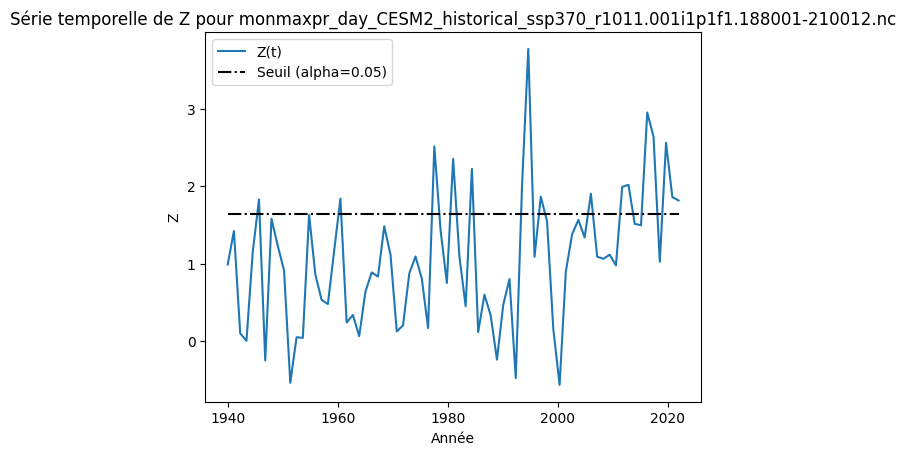

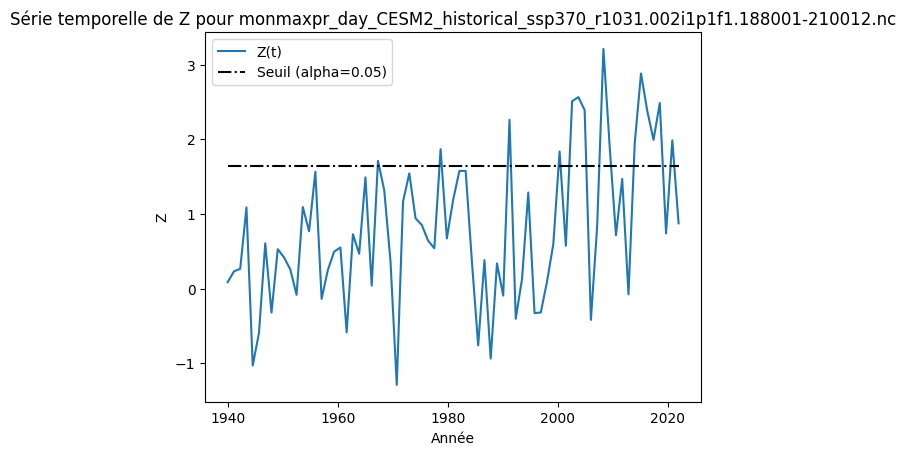

In [20]:
# Paramètre du test
alpha = 0.05
seuil = stats.norm.ppf(1 - alpha)

# Pour chaque fichier, on trace la série temporelle de Z
for res in resultats:
    fichier = res["fichier_test"]
    Z_series = res["Z_serie"]

    # On crée un axe temporel. Ici on suppose que les années commencent en 1940
    # et que la longueur de la série correspond au nombre d'années.
    annees = np.linspace(1940, 2022, len(Z_series))

    plt.figure()
    plt.plot(annees, Z_series, label="Z(t)")
    plt.hlines(y=seuil, xmin=annees[0], xmax=annees[-1], colors="black", linestyles="-.", label="Seuil (alpha=0.05)")
    plt.xlabel("Année")
    plt.ylabel("Z")
    plt.title(f"Série temporelle de Z pour {fichier}")
    plt.legend()
    plt.show()



In [ ]:
for res in resultats:
  val = np.arange(1940, 1940 + 85, 1)
  plt.plot(val, Z_obs, label='Z')
  plt.hlines(y=s, xmin=1940, xmax=1940 + len(Z_obs), color='black', linestyles='-.', label='Seuil')
  plt.xlabel('Année')
  plt.ylabel('Z')
  plt.title('Série temporelle de Z')
  plt.legend()
  plt.show()